Подключаем нужные пакеты

In [122]:
from typing import Tuple, Optional
import numpy as np
from skimage.morphology import binary_closing
from scipy.ndimage import binary_fill_holes
from skimage.feature import canny
import cv2
import matplotlib.pyplot as plt

Подключаем библиотку с алгоритмом

In [123]:
from intelligent_placer_lib.intelligent_placer import *

Путь до файла:

In [182]:
path = "data/input/yes/test9.jpg"

Для начала получим контуры листа и многоугольника. </br>
Контур листа должен быть помечен красным цветом, многоугольника - зеленым

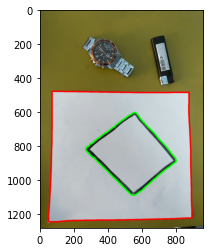

In [183]:
image = cv2.imread(path)
polygon_contours, paper_contours = find_paper_and_polygon_contours(path)
cv2.drawContours(image, [paper_contours], 0, (255, 0, 0), 8)
cv2.drawContours(image, [polygon_contours], 0, (0, 255, 0), 8)
plt.imshow(image)

Далее нам нужно найти контуры предметов. <br/>
Так как по постановке задачи предметы всегда находятся выше листа бумаги, то найдем самую верхнюю координату листа:

In [184]:
min_paper_y = min(paper_contours, key=lambda coordinates: coordinates[0][1])[0][1]
print(min_paper_y)

477


И обрежем изображение по этой координате

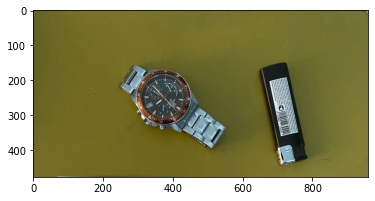

In [185]:
objects_image = cv2.imread(path)[:min_paper_y, :]
plt.imshow(objects_image)

Теперь будет легче определять предметы.
Далее найдём контуры предметов

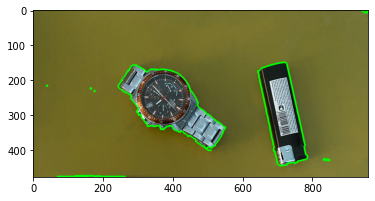

In [186]:
contours = find_all_contours(objects_image)
objects = find_all_objects(contours)
cv2.drawContours(objects_image, objects, -1, (0, 255, 0), thickness=4)
plt.imshow(objects_image)

Видно, что есть шумы при обпределение контуров объектов, но далее они не будут использоваться при поиске прямоугольников
для объектов

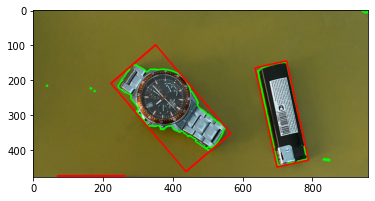

In [187]:
(h, w, d) = image.shape
rectangles = find_rectangles_for_objects(objects, h, w)
cv2.drawContours(objects_image, rectangles, -1, (255, 0, 0), 4)
plt.imshow(objects_image)

Были найдены прямоугольники, которые определяют границы предметов.
Теперь найдём их площади и сравним с площадью многоугольника, куда этим предметы нужно поместить. Это базовая реализация алгоритма. На следующей итерации постараюсь изменить алгоритм, например, на параллельный перенос или какой-то другой способ поиска ответа на поставленный вопрос в постановке задачи.

In [188]:
sum = 0
for rect in rectangles:
    sum += cv2.contourArea(rect)

print(cv2.contourArea(polygon_contours) >= sum)

True
